# Mobility and collapse height input weights for importance sampling

This notebook runs through the process of generating the weight factors associated with each energy cone simulation ($W_k$). This notebook outputs a file ('input_weights.csv') into the 'weighting_data' folder, which is used for importance sampling in the accompanying 'Importance_sampling_notebook'.

This notebook requires the file:

- 'initial_input_weights.csv' <-- containing the $\phi$-$H_0$ parameter pairs used for energy cone simulations. Provided in the 'source_files' folder

As the energy cone model requires two main input parameters: PDC mobility $\phi$, and Collapse height above the vent $H_0$, the weight factor of each parameter is combined to create an overall weight factor. This notebook first runs through the process of calculating the weight associated with $\phi$, and then the weight associated with $H_0$. Finally, it combines these to generate the overall weight $W_k$, for each energy cone simulation.

### Notebook Author
Ben Clarke <br /> 
https://github.com/GeoBen93 <br /> 
https://www.researchgate.net/profile/Ben_Clarke6 <br /> 
https://twitter.com/PyroclasticBen

### Visual overview of what this notebook does

\begin{equation}
    W_k = \frac{f(H_k) \times f(\phi_k)}{g(H_k) \times g(\phi_k)}
\end{equation}

----------------------------

![title](source_files/input_weight_calculation.png)

In [3]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
from scipy import stats
from scipy.stats import norm, truncnorm
from numpy import random

## PDC mobility weight

The first functions here define the target and uniform PDFs for PDC mobility. The parameters of the target PDF and limits of the uniform PDF are defined here as:

- phimin <-- Minimum $\phi$ value
- phimax <-- Maximum $\phi$ value
- phimean <-- Mean (or $\mu$) of $\phi$
- phistd <-- Standard deviation (or $\Sigma$) of $\phi$

In this case, these values are based on the distribution of a filtered analogue PDC data set (FlowDat, Ogburn (2012)).

In [4]:
phimin = 2
phimax = 30
phimean = 15.18
phistd = 6.3

def truncnormpdf_phi(x):
    a, b = (phimin - phimean) / phistd, (phimax - phimean) / phistd
    y = truncnorm.pdf(x, a, b, loc=phimean, scale=phistd)
    return y

def uniformpdf_phi(x):
    if x <= phimin:
        y = 0
    elif phimin <= x <= phimax:
        y = 1 / (phimax-phimin)
    elif x >= phimax:
        y = 0
    return y

We can use these to calculate the weight factor associated with the PDC mobility for each simulation ($W(\phi_k)$). Using the following equation:

\begin{equation}
W(\phi_k) = \frac{f(\phi_k)}{g(\phi_k)}
\end{equation}

where $f(\phi_k)$ is the infinitesimal probability of the target PDF at $\phi$ for simulation $k$. And $g(\phi_k)$ is the infinitesimal probability of the uniform PDF at $\phi$ for simulation $k$

In [5]:
df = pd.read_csv('source_files/initial_input_weights.csv')
df['phi_weight'] = df['phi'].apply((lambda x: truncnormpdf_phi(x)/uniformpdf_phi(x)))

## Collapse Height Weight

The next job is to create the target PDF for collapse height ($H_0$) for PDCs at Aluto. Recent work from Clarke (2020, in prep.), has shown that the PlumeRise model (Woodhouse, 2013) allows for the estimation of the height of the gas thrust region (assumed to equal $H_0$), given a vent radius ($r$, (m)) and water content of the magma ($H_2O$, (wt%)):

\begin{equation}
H_0 = a \cdot H_2O^{b} \cdot r^{c}
\end{equation}

By maximum-likelihood estimation, Clarke (2020, in prep.) found that for peralkaline rhyolite eruptions at Aluto: $a = 12.78$, $b = -0.61$ and $c = 1.1$.

In [6]:
a = 12.78
b = -0.61
c = 1.1

def plume_func(radius, water): 
    h0 = a * (water**b) * (radius**c)
    return h0

To create a target PDF (or in this case a normalised histogram), we can evaluate the equation above for the range and distribution of $H_2O$ and $r$ expected at the volcano. At Aluto, these have been estimated as:

- $H_2O$ <-- uniform distribution between 4% and 8%
- $r$ <-- triangular distribution (left = 10m, mode = 10m, right = 100m)

(see Clarke et al. (in prep.), and Clarke (PhD thesis - 2020) for reasoning)

We evaluate this equation $2 \times 10^6$ times, each with a randomly sampled $H_2O$ and $r$, and plot a histogram of the resulting $H_0$ to see the distribution. This takes a few seconds.

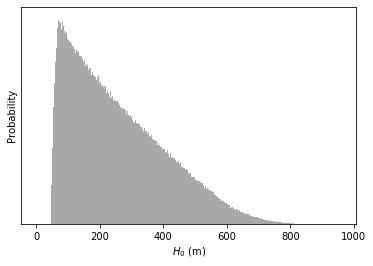

In [7]:
h0_list = []

counter = 0
while counter < 2000000:
    # call random gas content and vent radius within range at Aluto
    radius = random.triangular(left = 10, mode = 10, right = 100)
    water = random.uniform(4, 8)
    
    # perform calculations based on these
    h0 = plume_func(radius, water)

    # append results to a list
    h0_list.append(h0)
    # add to the counter
    counter += 1
    
fig = plt.figure('Collapse Height')

ax1 = fig.add_subplot(111)

bins = np.linspace(0, np.max(h0_list) + 100 ,1000)
h0_hist = ax1.hist(h0_list, bins, color='darkgray', density=True)
ax1.set_yticks([])
ax1.set_xlabel('$H_0$ (m)')
ax1.set_ylabel('Probability')

plt.show()

The next step is to take this normalised histogram (a sort of 'pseudo-PDF'), and use it to calculate the weight factor associated with the $H_0$ for each simulation ($W(H_k)$). This is done by the following equation:

\begin{equation}
W(H_k) = \frac{f(H_k)}{g(H_k)}
\end{equation}

where $f(H_k)$ is the infinitesimal probability of the target PDF at $H_0$ for simulation $k$. And $g(H_k)$ is the infinitesimal probability of the uniform PDF at $H_0$ for simulation $k$.

For each simulation, we need to find $f(H_k)$: the value of the normalised histogram at the value of $H_0$ in the simulation. As the histogram is not a continuous PDF, we find the central value of the histogram bin containing the continuous value of $H_0$. Due to the very large number of iterations used to generate this histogram, and the narrow bin width, this closely approximates a continuous function.

In [8]:
# calculate uniform PDF
tallest = plume_func(100, 4)
shortest = plume_func(10, 8)
uniform_h0 = 1 / (tallest - shortest) 

#next find the probability density of the target pdf at each input collapse height and using this and the above to calculate the weight factor
def find_factor(lookup_hist, lookup):
    #find index of item in list with closest value
    closest_index = min(range(len(lookup_hist[1])), key=lambda i: abs(lookup_hist[1][i]-lookup))
    #find value of PDF at this index
    factor = lookup_hist[0][closest_index]
    return factor

df['h0_weight'] = df['hc'].apply((lambda x: find_factor(h0_hist, x)/uniform_h0 ))

Finally, we need to calculate the overall input weight factor for each simulation ($W_k$), where:

\begin{equation}
W_k = W(\phi_k) \cdot W(H_k)
\end{equation}

We can then visualise the results, and save them to a .csv named 'input_weights.csv', in the 'notebook_output_files' folder. This file, is imported and used in the accompanying importance sampling notebook.

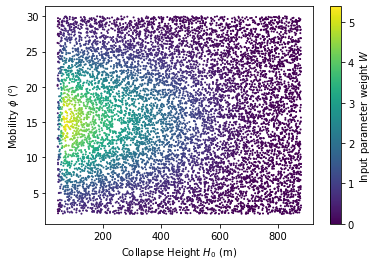

In [9]:
df['input_weight'] = df['phi_weight'] * df['h0_weight']

plt.scatter(df['hc'], df['phi'], c=df['input_weight'], s=1)
plt.xlabel('Collapse Height $H_0$ (m)')
plt.ylabel('Mobility $\phi$ ($^o$)')
plt.colorbar(label='Input parameter weight $W$')
plt.show()

df.to_csv('notebook_output_files/input_weights.csv')